# Data Loading Pipeline for Emotion Recognition

This notebook implements the data loading pipeline for the emotion recognition project.

**Goal:** Load face images and their corresponding 13-dimensional emotion probability distributions.

**Dataset Structure:**
- Images: `xxx.jpg`
- Annotations: `xxx_prob_rank.txt` (13 probability values)
- Emotions: neutral, happy, sad, surprised, fear, disgust, angry, contempt, serene, contemplative, secure, untroubled, quiet

## 1. Imports and Setup
Import all necessary libraries for data loading, visualization, and PyTorch.

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Emotion labels in order
EMOTION_LABELS = [
    'neutral', 'happy', 'sad', 'surprised', 'fear', 'disgust', 'angry',
    'contempt', 'serene', 'contemplative', 'secure', 'untroubled', 'quiet'
]

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

## 2. Explore Dataset Structure
Check the dataset folder structure and count train/validation samples.

In [2]:
# Define dataset paths
DATASET_ROOT = Path('AffectNetFused')
TRAIN_IMAGES_DIR = DATASET_ROOT / 'train_set' / 'images'
TRAIN_ANNOTS_DIR = DATASET_ROOT / 'train_set' / 'annotations'
VAL_IMAGES_DIR = DATASET_ROOT / 'val_set' / 'images'
VAL_ANNOTS_DIR = DATASET_ROOT / 'val_set' / 'annotations'

# Count files (images vs annotations)
def count_files(images_dir, annots_dir):
    """Count image and annotation files in separate directories."""
    if not images_dir.exists() or not annots_dir.exists():
        return 0, 0
    
    images = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png'))
    annotations = list(annots_dir.glob('*_prob_rank.txt'))
    
    return len(images), len(annotations)

train_imgs, train_annots = count_files(TRAIN_IMAGES_DIR, TRAIN_ANNOTS_DIR)
val_imgs, val_annots = count_files(VAL_IMAGES_DIR, VAL_ANNOTS_DIR)

print(f"📊 Dataset Statistics:")
print(f"  Training set: {train_imgs} images, {train_annots} annotations")
print(f"  Validation set: {val_imgs} images, {val_annots} annotations")
print(f"  Total: {train_imgs + val_imgs} images")
print(f"\n📂 Dataset Structure:")
print(f"  Train images: {TRAIN_IMAGES_DIR}")
print(f"  Train annotations: {TRAIN_ANNOTS_DIR}")
print(f"  Val images: {VAL_IMAGES_DIR}")
print(f"  Val annotations: {VAL_ANNOTS_DIR}")

📊 Dataset Statistics:
  Training set: 308468 images, 308468 annotations
  Validation set: 3999 images, 3999 annotations
  Total: 312467 images

📂 Dataset Structure:
  Train images: AffectNetFused\train_set\images
  Train annotations: AffectNetFused\train_set\annotations
  Val images: AffectNetFused\val_set\images
  Val annotations: AffectNetFused\val_set\annotations


## 3. Load and Visualize Sample
Load one sample image with its emotion probability distribution and visualize both.

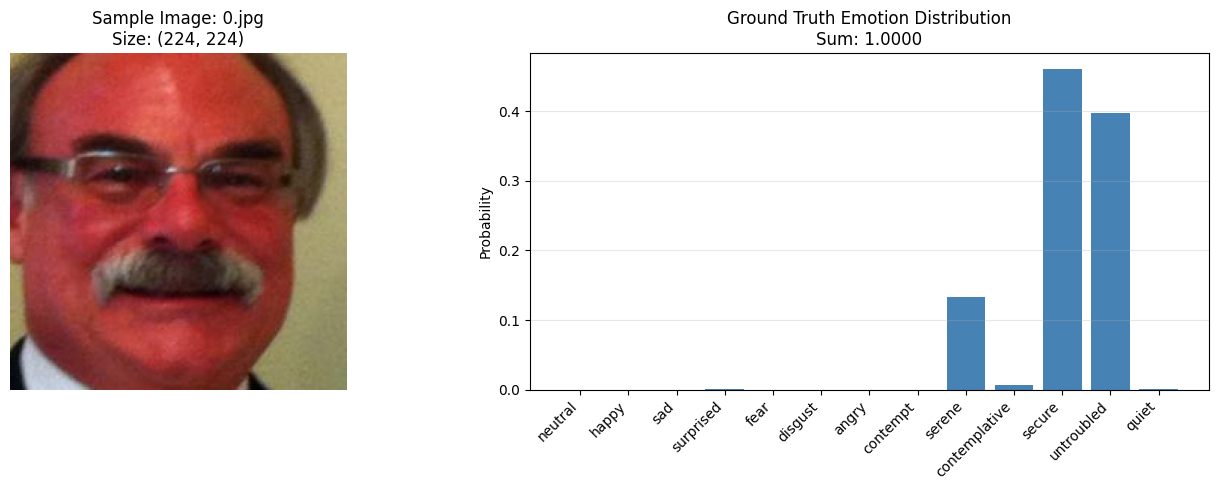


🎭 Top 3 emotions:
  secure: 0.4604
  untroubled: 0.3972
  serene: 0.1327

📄 Note: For each image, there are 7 annotation files:
  - 0_prob_rank.txt ← We use this one (comma-separated)
  - Plus: _aro.npy, _exp.npy, _Ind.npy, _rank.txt, _term.txt, _val.npy


In [3]:
def load_sample(images_dir, annots_dir, index=0):
    """Load a single sample (image + probabilities) from the dataset."""
    # Get image files from images directory
    image_files = sorted(list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png')))
    if not image_files:
        raise ValueError(f"No images found in {images_dir}")
    
    img_path = image_files[index]
    
    # Construct annotation path in annotations directory
    annot_path = annots_dir / f"{img_path.stem}_prob_rank.txt"
    
    if not annot_path.exists():
        raise ValueError(f"Annotation not found: {annot_path}")
    
    # Load image
    image = Image.open(img_path).convert('RGB')
    
    # Load probabilities (comma-separated values on a single line)
    with open(annot_path, 'r') as f:
        line = f.read().strip()
        probs = [float(val) for val in line.split(',')]
    
    return image, np.array(probs), img_path.name

# Load a sample from training set
sample_img, sample_probs, sample_name = load_sample(TRAIN_IMAGES_DIR, TRAIN_ANNOTS_DIR, index=0)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot image
axes[0].imshow(sample_img)
axes[0].set_title(f'Sample Image: {sample_name}\nSize: {sample_img.size}')
axes[0].axis('off')

# Plot probability distribution
axes[1].bar(range(len(EMOTION_LABELS)), sample_probs, color='steelblue')
axes[1].set_xticks(range(len(EMOTION_LABELS)))
axes[1].set_xticklabels(EMOTION_LABELS, rotation=45, ha='right')
axes[1].set_ylabel('Probability')
axes[1].set_title(f'Ground Truth Emotion Distribution\nSum: {sample_probs.sum():.4f}')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print top emotions
top_indices = np.argsort(sample_probs)[::-1][:3]
print("\n🎭 Top 3 emotions:")
for idx in top_indices:
    print(f"  {EMOTION_LABELS[idx]}: {sample_probs[idx]:.4f}")

# Show annotation files info
print(f"\n📄 Note: For each image, there are 7 annotation files:")
print(f"  - {sample_name.replace('.jpg', '_prob_rank.txt')} ← We use this one (comma-separated)")
print(f"  - Plus: _aro.npy, _exp.npy, _Ind.npy, _rank.txt, _term.txt, _val.npy")

## 4. PyTorch Dataset Class
Implement a custom Dataset class for loading emotion recognition data.

In [4]:
class EmotionDataset(Dataset):
    """
    PyTorch Dataset for emotion recognition with probability distributions.
    
    Args:
        images_dir: Path to images directory (e.g., train_set/images)
        annots_dir: Path to annotations directory (e.g., train_set/annotations)
        transform: Optional transform to apply to images
        target_transform: Optional transform to apply to probability distributions
    """
    
    def __init__(self, images_dir, annots_dir, transform=None, target_transform=None):
        self.images_dir = Path(images_dir)
        self.annots_dir = Path(annots_dir)
        self.transform = transform
        self.target_transform = target_transform
        
        # Get all image files from images directory
        self.image_files = sorted(
            list(self.images_dir.glob('*.jpg')) + 
            list(self.images_dir.glob('*.png'))
        )
        
        # Verify each image has corresponding annotation
        self._verify_annotations()
        
    def _verify_annotations(self):
        """Verify all images have corresponding annotation files."""
        valid_files = []
        missing_annots = []
        
        for img_path in self.image_files:
            annot_path = self.annots_dir / f"{img_path.stem}_prob_rank.txt"
            if annot_path.exists():
                valid_files.append(img_path)
            else:
                missing_annots.append(img_path.name)
        
        self.image_files = valid_files
        
        if missing_annots:
            print(f"⚠ Warning: {len(missing_annots)} images without annotations (skipped)")
            if len(missing_annots) <= 5:
                for name in missing_annots:
                    print(f"    Missing: {name}")
        
        print(f"✓ Verified {len(self.image_files)} samples in {self.images_dir.parent.name}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        """Load and return a single sample (image, probability distribution)."""
        # Load image from images directory
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Load probabilities from annotations directory (comma-separated values)
        annot_path = self.annots_dir / f"{img_path.stem}_prob_rank.txt"
        with open(annot_path, 'r') as f:
            line = f.read().strip()
            probs = np.array([float(val) for val in line.split(',')], dtype=np.float32)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            probs = self.target_transform(probs)
        
        # Convert probabilities to tensor
        probs = torch.from_numpy(probs)
        
        return image, probs

print("✓ EmotionDataset class defined")

✓ EmotionDataset class defined


## 5. Create DataLoaders
Define image transforms and create DataLoaders for training and validation.

In [5]:
# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Data augmentation
    transforms.ToTensor(),  # Convert to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets with separate images and annotations directories
train_dataset = EmotionDataset(
    images_dir=TRAIN_IMAGES_DIR,
    annots_dir=TRAIN_ANNOTS_DIR,
    transform=train_transform
)

val_dataset = EmotionDataset(
    images_dir=VAL_IMAGES_DIR,
    annots_dir=VAL_ANNOTS_DIR,
    transform=val_transform
)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows, increase for Linux/Mac
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\n📦 DataLoaders created:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Batch size: {BATCH_SIZE}")

✓ Verified 308468 samples in train_set
✓ Verified 3999 samples in val_set

📦 DataLoaders created:
  Training samples: 308468
  Validation samples: 3999
  Training batches: 9640
  Validation batches: 125
  Batch size: 32


## 6. Test Batch Loading and Visualization
Load a batch and visualize multiple samples with their emotion distributions.

In [6]:
# Get a batch from the training loader
images_batch, probs_batch = next(iter(train_loader))

print(f"Batch shapes:")
print(f"  Images: {images_batch.shape}  # (batch, channels, height, width)")
print(f"  Probabilities: {probs_batch.shape}  # (batch, 13 emotions)")
print(f"\nProbability sum check (should be ~1.0):")
print(f"  Min: {probs_batch.sum(dim=1).min():.4f}")
print(f"  Max: {probs_batch.sum(dim=1).max():.4f}")
print(f"  Mean: {probs_batch.sum(dim=1).mean():.4f}")

Batch shapes:
  Images: torch.Size([32, 3, 224, 224])  # (batch, channels, height, width)
  Probabilities: torch.Size([32, 13])  # (batch, 13 emotions)

Probability sum check (should be ~1.0):
  Min: 1.0000
  Max: 1.0000
  Mean: 1.0000


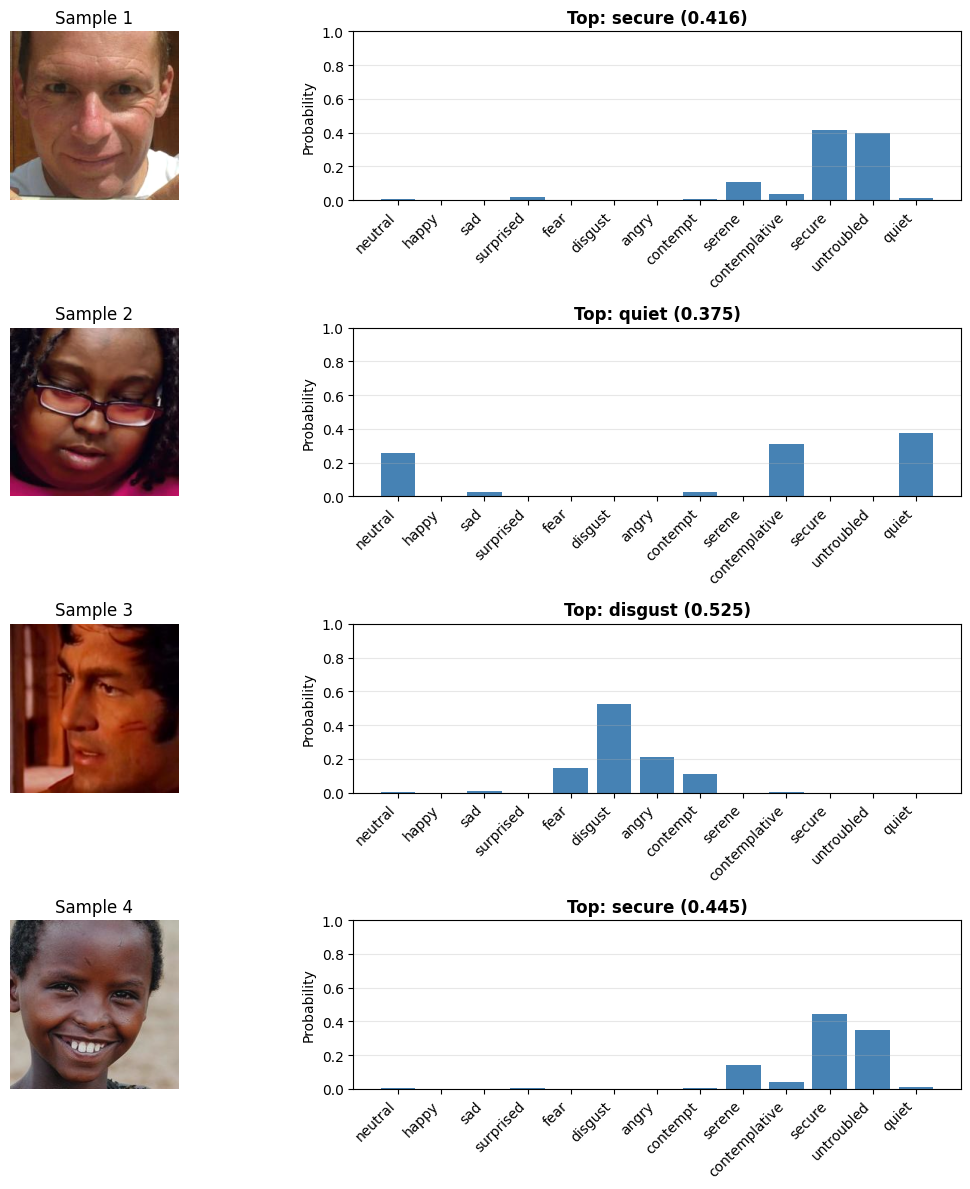

In [7]:
def denormalize(tensor):
    """Denormalize image tensor for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def visualize_batch(images, probs, num_samples=4):
    """Visualize samples from a batch with their emotion distributions."""
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3))
    
    for i in range(num_samples):
        # Denormalize and convert image to numpy
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Sample {i+1}')
        axes[i, 0].axis('off')
        
        # Plot probability distribution
        prob_values = probs[i].numpy()
        axes[i, 1].bar(range(len(EMOTION_LABELS)), prob_values, color='steelblue')
        axes[i, 1].set_xticks(range(len(EMOTION_LABELS)))
        axes[i, 1].set_xticklabels(EMOTION_LABELS, rotation=45, ha='right')
        axes[i, 1].set_ylabel('Probability')
        axes[i, 1].set_ylim(0, 1)
        axes[i, 1].grid(axis='y', alpha=0.3)
        
        # Annotate top emotion
        top_idx = prob_values.argmax()
        axes[i, 1].set_title(
            f'Top: {EMOTION_LABELS[top_idx]} ({prob_values[top_idx]:.3f})',
            fontweight='bold'
        )
    
    plt.tight_layout()
    plt.show()

# Visualize 4 samples from the batch
visualize_batch(images_batch, probs_batch, num_samples=4)

## 7. Distribution Statistics
Analyze the emotion probability distributions in the dataset.

Loading from cache: cache_train_probs.pkl
✓ Collected 308468 samples


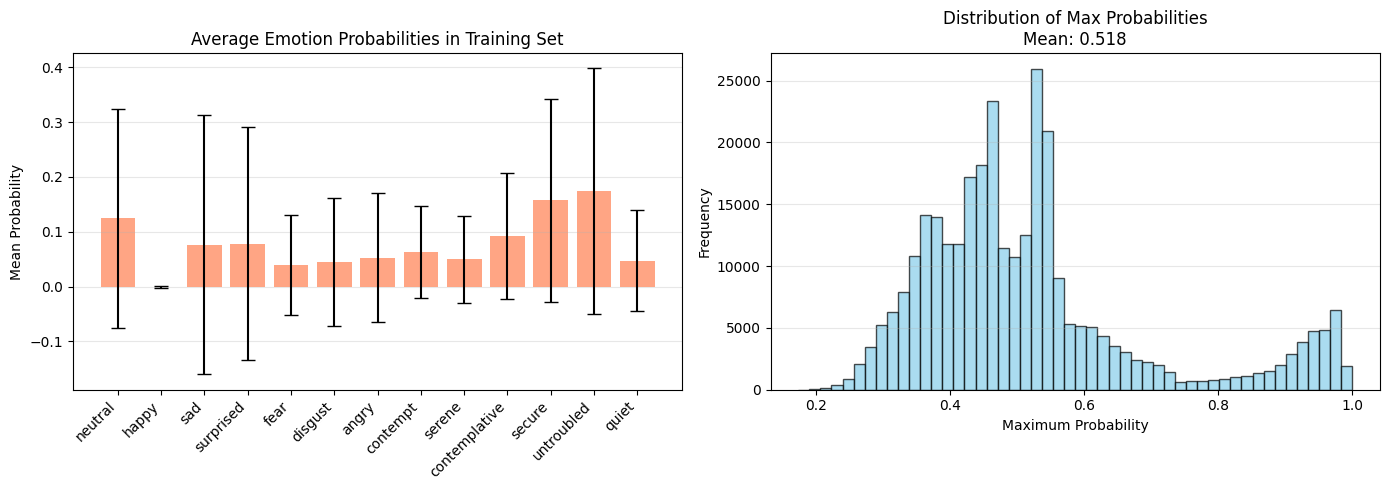


📊 Dataset Statistics:
  Total samples analyzed: 308468
  Mean max probability: 0.5182 ± 0.1720

  Most common emotions (by mean probability):
    untroubled: 0.1744
    secure: 0.1574
    neutral: 0.1247
    contemplative: 0.0921
    surprised: 0.0781


In [12]:
# Collect statistics from training set - optimized with caching
print("Collecting probability distributions from training set...")

import pickle
from concurrent.futures import ThreadPoolExecutor

def load_single_prob_file(annot_path):
    """Load a single annotation file."""
    with open(annot_path, 'r') as f:
        line = f.read().strip()
        return [float(val) for val in line.split(',')]

def load_all_probabilities(annots_dir, cache_path=None):
    """Load all probability distributions with parallel processing and caching."""
    
    # Check cache first
    if cache_path and cache_path.exists():
        print(f"Loading from cache: {cache_path}")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    
    # Load annotation files
    annot_files = sorted(list(annots_dir.glob('*_prob_rank.txt')))
    print(f"Found {len(annot_files)} annotation files")
    
    # Use parallel processing for faster loading
    all_probs = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(
            executor.map(load_single_prob_file, annot_files),
            total=len(annot_files),
            desc="Loading annotations"
        ))
    
    all_probs = np.array(results, dtype=np.float32)
    
    # Save to cache
    if cache_path:
        print(f"Saving to cache: {cache_path}")
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        with open(cache_path, 'wb') as f:
            pickle.dump(all_probs, f)
    
    return all_probs

# Load with caching
cache_file = Path('cache_train_probs.pkl')
all_probs = load_all_probabilities(TRAIN_ANNOTS_DIR, cache_path=cache_file)
print(f"✓ Collected {len(all_probs)} samples")

# Calculate mean probability for each emotion
mean_probs = all_probs.mean(axis=0)
std_probs = all_probs.std(axis=0)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean probabilities
axes[0].bar(range(len(EMOTION_LABELS)), mean_probs, color='coral', alpha=0.7)
axes[0].errorbar(range(len(EMOTION_LABELS)), mean_probs, yerr=std_probs, 
                 fmt='none', ecolor='black', capsize=5)
axes[0].set_xticks(range(len(EMOTION_LABELS)))
axes[0].set_xticklabels(EMOTION_LABELS, rotation=45, ha='right')
axes[0].set_ylabel('Mean Probability')
axes[0].set_title('Average Emotion Probabilities in Training Set')
axes[0].grid(axis='y', alpha=0.3)

# Distribution of maximum probability values
max_probs = all_probs.max(axis=1)
axes[1].hist(max_probs, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Maximum Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Distribution of Max Probabilities\nMean: {max_probs.mean():.3f}')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Dataset Statistics:")
print(f"  Total samples analyzed: {len(all_probs)}")
print(f"  Mean max probability: {max_probs.mean():.4f} ± {max_probs.std():.4f}")
print(f"\n  Most common emotions (by mean probability):")
for idx in np.argsort(mean_probs)[::-1][:5]:
    print(f"    {EMOTION_LABELS[idx]}: {mean_probs[idx]:.4f}")

## Summary

✓ Data loading pipeline is ready!

**What we've implemented:**
1. Custom `EmotionDataset` class for loading images and probability distributions
2. Image transforms with augmentation for training
3. DataLoaders for efficient batch loading
4. Visualization functions for exploring the data
5. Dataset statistics and distribution analysis

**Next steps:**
- Design model architecture with 13-output head
- Implement loss functions (MSE, KL Divergence, etc.)
- Create training loop
- Implement evaluation metrics